<H1>Data analysis and machine learning using custom Neural Network (w/o any scify libraries)</H1>
This is my first kernel at Kaggle. I am also a beginner in data science and machine learning.

To understand details and advanced concepts in ML, I thought I'll start with simple concepts for my learning or for anyone else in my position.

As a result, below is a simple neural network made from scratch in python. I will be updating the text explaining the basics of the network and creating new (and simple) network for different datasets as I go along.

Comments/Crits/Corrections welcome. Thanks!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
import matplotlib.pyplot as plt

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

<H2>Load Data</H2>

In [2]:
# load iris database
data = pd.read_csv('Iris.csv')
data.sample(n=5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
82,83,5.8,2.7,3.9,1.2,Iris-versicolor
34,35,4.9,3.1,1.5,0.1,Iris-setosa
35,36,5.0,3.2,1.2,0.2,Iris-setosa
5,6,5.4,3.9,1.7,0.4,Iris-setosa
146,147,6.3,2.5,5.0,1.9,Iris-virginica


In [3]:
data.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


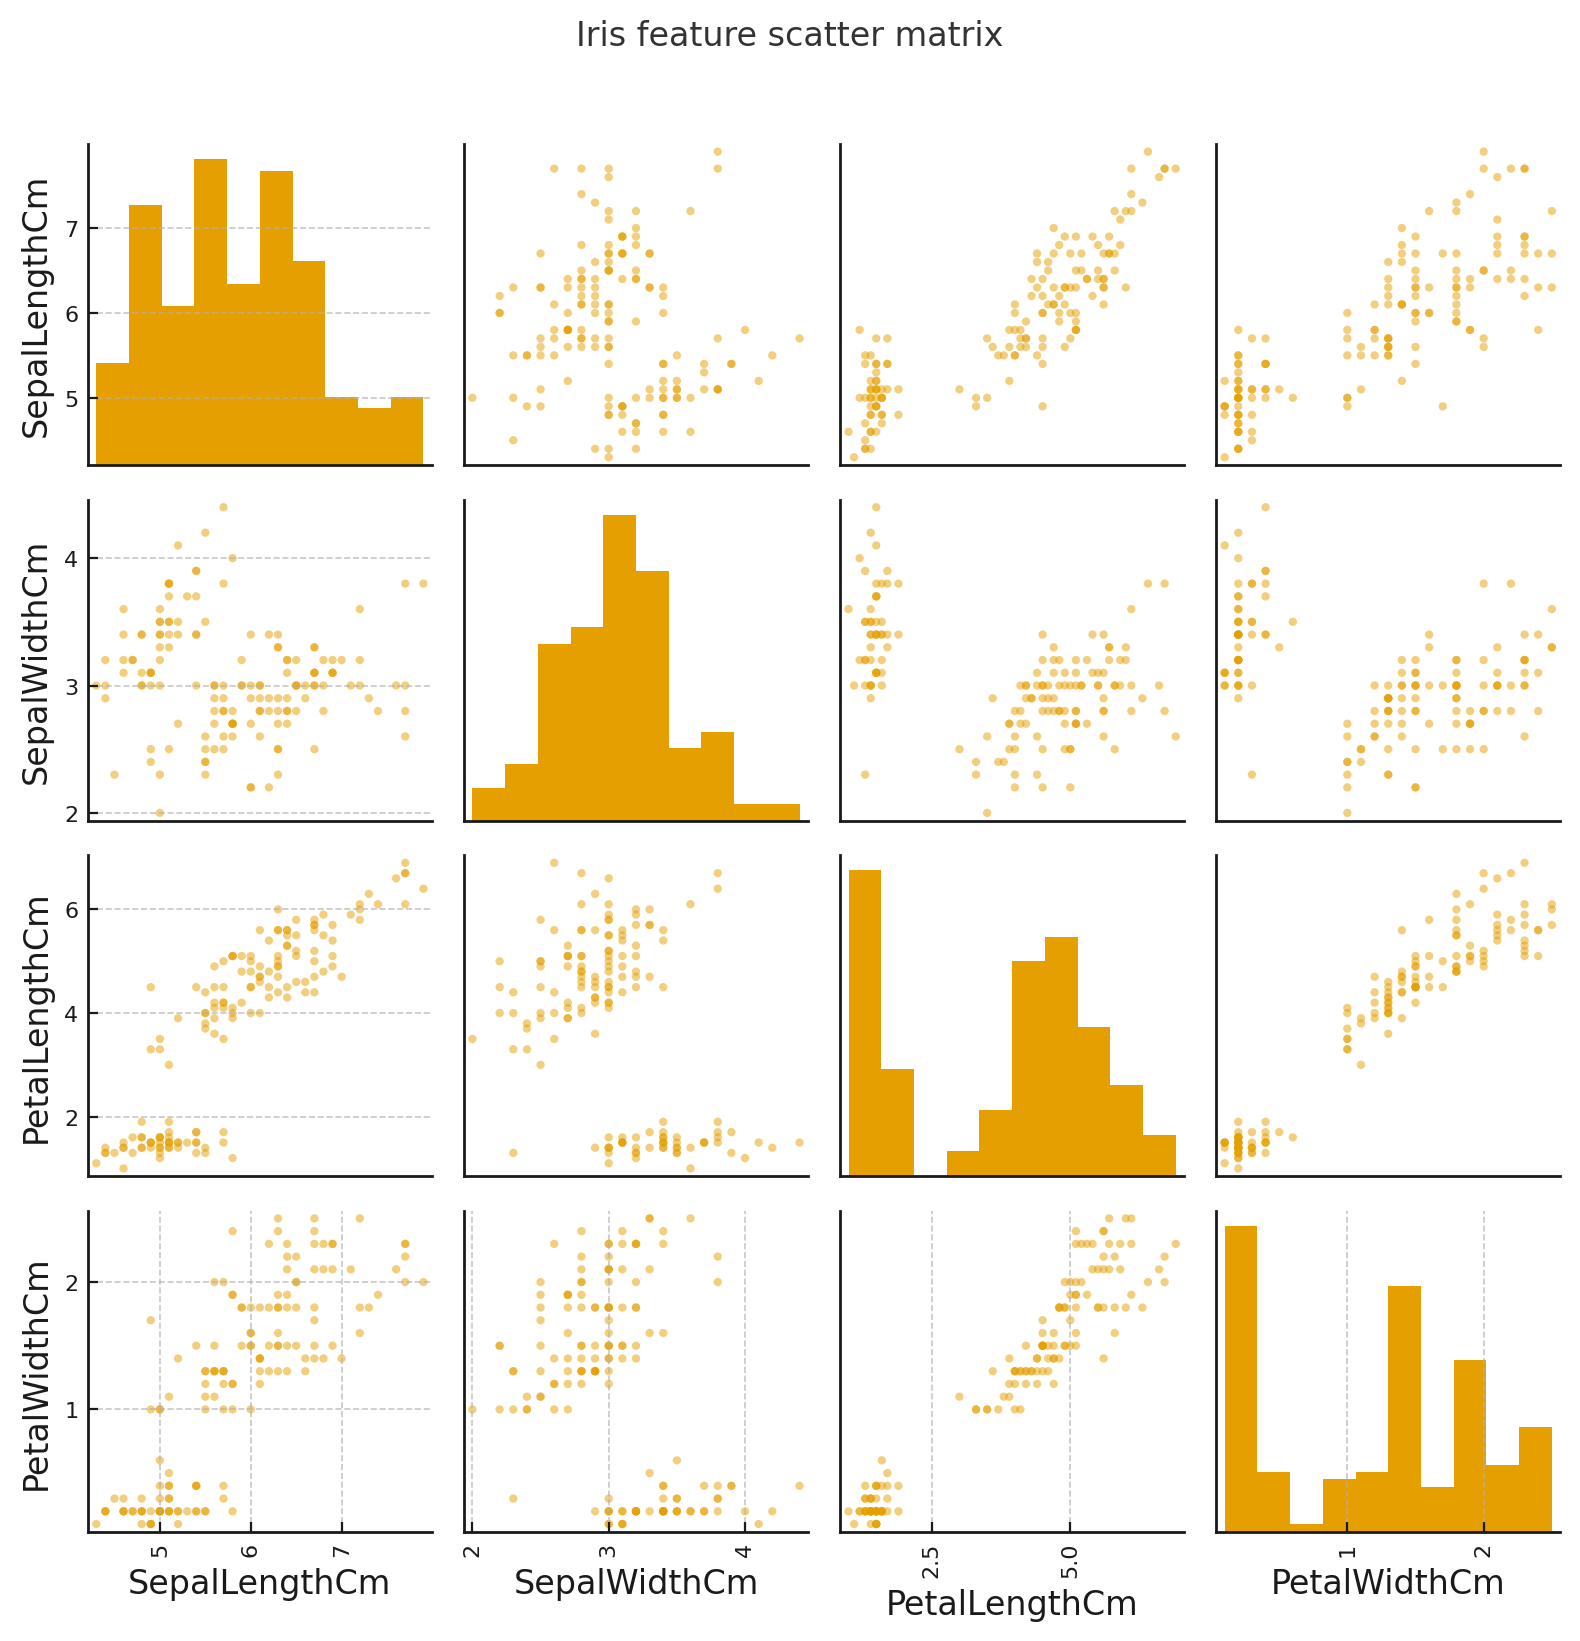

In [4]:
# Robust scatter matrix using pandas + matplotlib (avoids seaborn type issues)
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Ensure `data` exists and is numeric for selected vars
try:
    df_plot = data.copy()
except NameError:
    # Fallback: try common variable
    df_plot = df.copy()

vars_cols = ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']
for c in vars_cols:
    df_plot[c] = pd.to_numeric(df_plot[c], errors='coerce')

# Simple scatter matrix (no hue). We'll split by species in a loop for clarity.
species = df_plot['Species'].unique().tolist()
axarr = scatter_matrix(df_plot[vars_cols], figsize=(8, 8), diagonal='hist')
plt.suptitle("Iris feature scatter matrix", y=1.02)
plt.tight_layout()

<H2>Normalize the data</H2>

In [5]:
df_norm = data[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_norm.sample(n=5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
98,0.222222,0.208333,0.338983,0.416667
130,0.861111,0.333333,0.864407,0.750000
81,0.333333,0.166667,0.457627,0.375000
56,0.555556,0.541667,0.627119,0.625000
93,0.194444,0.125000,0.389831,0.375000


In [6]:
df_norm.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.439167,0.467571,0.457778
std,0.230018,0.180664,0.299054,0.317984
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


Convert the Species labels to indexes for use with neural network.<BR>
Iris-setoso = 0<BR>
Iris-versicolor = 1<BR>
Iris-virginica = 2<BR>

In [7]:
target = data[['Species']].replace(['Iris-setosa','Iris-versicolor','Iris-virginica'],[0,1,2])
target.sample(n=5)

,Species
79,1
80,1
63,1
55,1
25,0


In [8]:
df = pd.concat([df_norm, target], axis=1)
df.sample(n=5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
44,0.222222,0.750000,0.152542,0.125000,0
20,0.305556,0.583333,0.118644,0.041667,0
135,0.944444,0.416667,0.864407,0.916667,2
102,0.777778,0.416667,0.830508,0.833333,2
103,0.555556,0.375000,0.779661,0.708333,2


<H2>Mark some of the data for testing purpose.</H2>
We'll test our network on unseen data.

In [9]:
train_test_per = 90/100.0
df['train'] = np.random.rand(len(df)) < train_test_per
df.sample(n=5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,train
103,0.555556,0.375000,0.779661,0.708333,2,True
70,0.444444,0.500000,0.644068,0.708333,1,True
129,0.805556,0.416667,0.813559,0.625000,2,True
75,0.638889,0.416667,0.576271,0.541667,1,True
59,0.250000,0.291667,0.491525,0.541667,1,True


<H2>Separate train and test Data</H2>

In [10]:
train = df[df.train == 1]
train = train.drop('train', axis=1).sample(frac=1)
train.sample(n=5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
75,0.638889,0.416667,0.576271,0.541667,1
67,0.416667,0.291667,0.525424,0.375000,1
87,0.555556,0.125000,0.576271,0.500000,1
144,0.666667,0.541667,0.796610,1.000000,2
82,0.416667,0.291667,0.491525,0.458333,1


In [11]:
test = df[df.train == 0]
test = test.drop('train', axis=1)
test.sample(n=5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
42,0.027778,0.500000,0.050847,0.041667,0
112,0.694444,0.416667,0.762712,0.833333,2
8,0.027778,0.375000,0.067797,0.041667,0
89,0.333333,0.208333,0.508475,0.500000,1
94,0.361111,0.291667,0.542373,0.500000,1


In [12]:
X = train.values[:,:4]
X[:5]

array([[0.58333333, 0.5       , 0.59322034, 0.58333333],
       [0.5       , 0.41666667, 0.61016949, 0.54166667],
       [0.38888889, 0.375     , 0.54237288, 0.5       ],
       [0.69444444, 0.33333333, 0.6440678 , 0.54166667],
       [0.13888889, 0.45833333, 0.10169492, 0.04166667]])

In [13]:
targets = [[1,0,0],[0,1,0],[0,0,1]]
y = np.array([targets[int(x)] for x in train.values[:,4:5]])
y[:5]

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]])

<H2>Create backpropagating neural network</H2>
Create 3 layers: Input, hidden and Output.

Inputs = length and widths of the species<BR>
Output = 3 values, each one indicating a species. ie Values 1, 0, 0 for the output indicates Iris-setosa<BR>
w1 is a matrices of weight connecting Input and the hidden layer. Each node in input layer connects to each node in the hidden layer.

Weight are randomized between -1 and 1.

In [14]:
num_inputs = len(X[0])
hidden_layer_neurons = 5
np.random.seed(4)
w1 = 2*np.random.random((num_inputs, hidden_layer_neurons)) - 1
w1

array([[ 0.93405968,  0.0944645 ,  0.94536872,  0.42963199,  0.39545765],
       [-0.56782101,  0.95254891, -0.98753949, -0.49403528, -0.13041694],
       [ 0.55876584, -0.60462985,  0.72598647,  0.96680135, -0.67231552],
       [ 0.19466789, -0.9820278 , -0.22685743, -0.91167988,  0.91330594]])

<H3>w2 are the weights of connections between hidden layer and output layer.</H3>

In [15]:
num_outputs = len(y[0])
w2 = 2*np.random.random((hidden_layer_neurons, num_outputs)) - 1
w2

array([[-0.12770671,  0.89795461,  0.57261197],
       [ 0.7325786 , -0.65366916, -0.85010283],
       [ 0.20148544, -0.66405563,  0.46676034],
       [-0.18311228,  0.05581765,  0.87514317],
       [ 0.04339224, -0.78361323, -0.68355319]])

<H2>Train the network by updating the weights using backpropogation.</H2>
This is the crux of the network. The layers are fed forward using sigmoid activation function. The weighs are then updated based on error using gradient descent.

<pre>
Forward Propagation ( use current weights to caluculate output ):
> node activation = output from previous layer (network inputs in case of first layer) * weights
> node output = sigmoid activation function = 1 / ( 1 + exp( node activation ) )

Backpropagation ( update network weights ):
Error calculation ( how far off we are from the expected values ):
> derivative (different for different activation functions) = output * ( 1 - output )
> error (for the last layer) = ( expected - output ) * derivative
> error (for other layers) = ( error calulated previously * that layer's weight ) * derivative
Update weight based on error caculated:
> Weight = weight + ( output * error * learning rate )
</pre>

In [16]:
# taken from> https://gist.github.com/craffel/2d727968c3aaebd10359
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

**A Graphical representations of our network will be something like below**<BR>
The first set of 4 nodes is the input.<BR>
The second set of 5 nodes is the hidden layer. <BR>
The last set of 3 nodes is the output layer.<BR><BR>
All the nodes of a layer are fully connected to all nodes of the next layer.

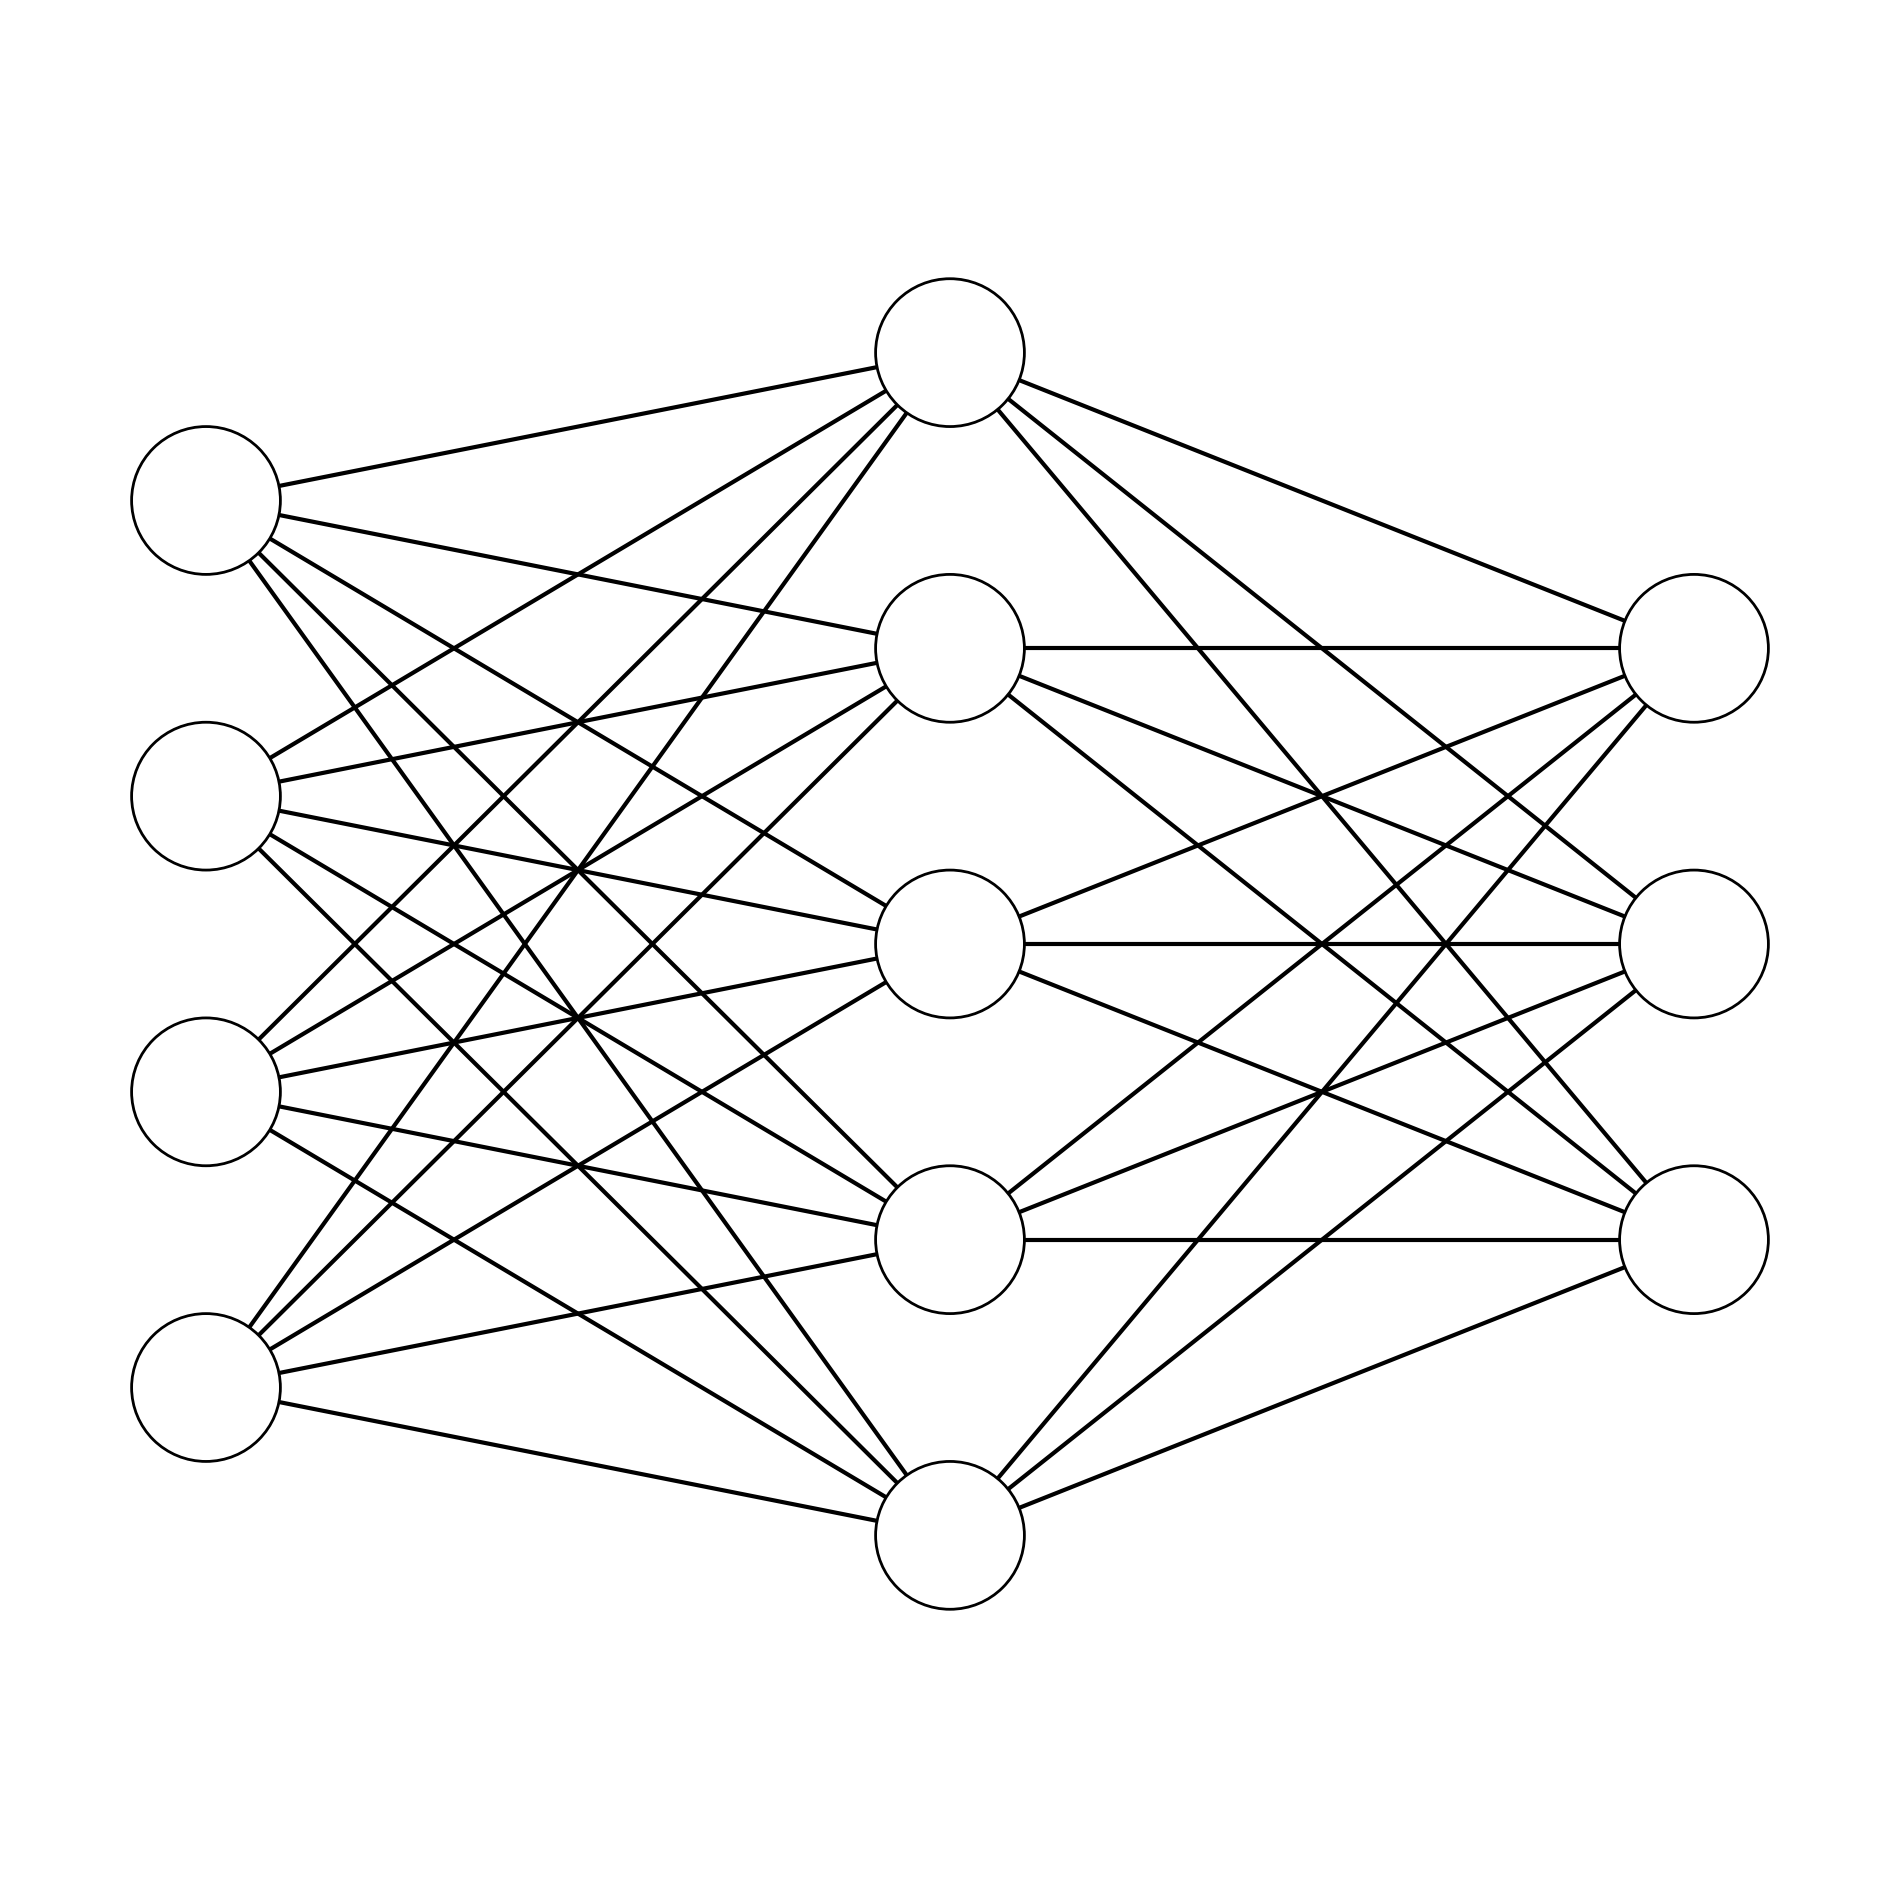

In [17]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [4, 5, 3])

The sigmoid activation function squashes the input values between 0 and 1. This provides a consistant way for the network to deal with outputs.

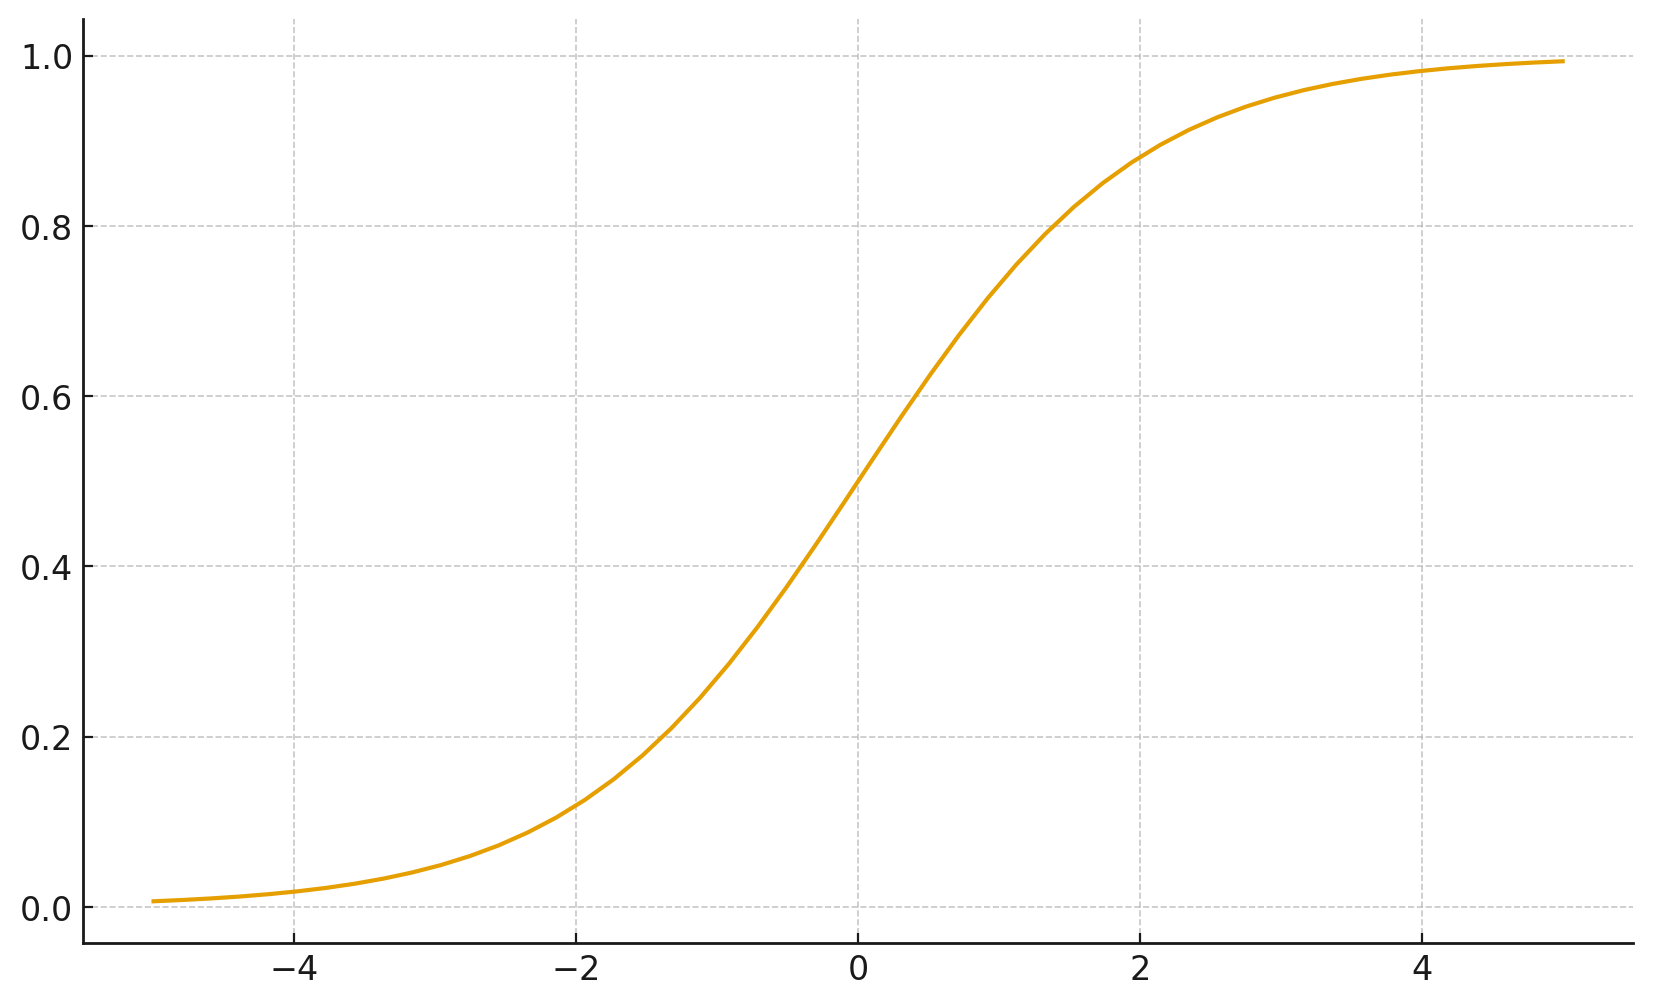

In [18]:
# sigmoid function representation
_x = np.linspace( -5, 5, 50 )
_y = 1 / ( 1 + np.exp( -_x ) )
plt.plot( _x, _y )

## Training

In [19]:
learning_rate = 0.2 # slowly update the network
error = []
for epoch in range(1000):
    # activate the first layer using the input
    #   matrix multiplication between the input and the layer 1 weights
    #   result is fed into a sigmoid function
    l1 = 1/(1 + np.exp(-(np.dot(X, w1))))
    # activate the second layer using first layer as input
    l2 = 1/(1 + np.exp(-(np.dot(l1, w2))))
    # find the average errorof this batch
    #   using absolute, can use use square as well
    er = (abs(y - l2)).mean()
    error.append(er)
    
    # BACKPROPAGATION / learning!
    # find contribution of error on each weight on the second layer
    l2_delta = (y - l2)*(l2 * (1-l2))
    # update each weight in the second layer slowly
    w2 += l1.T.dot(l2_delta) * learning_rate
    
    # find contribution of error on each weight on the second layer w.r.t the first layer
    l1_delta = l2_delta.dot(w2.T) * (l1 * (1-l1))
    # udpate weights in the first layer
    w1 += X.T.dot(l1_delta) * learning_rate
    
print('Error:', er)

Error: 0.11360249105260055


### Plotting Error

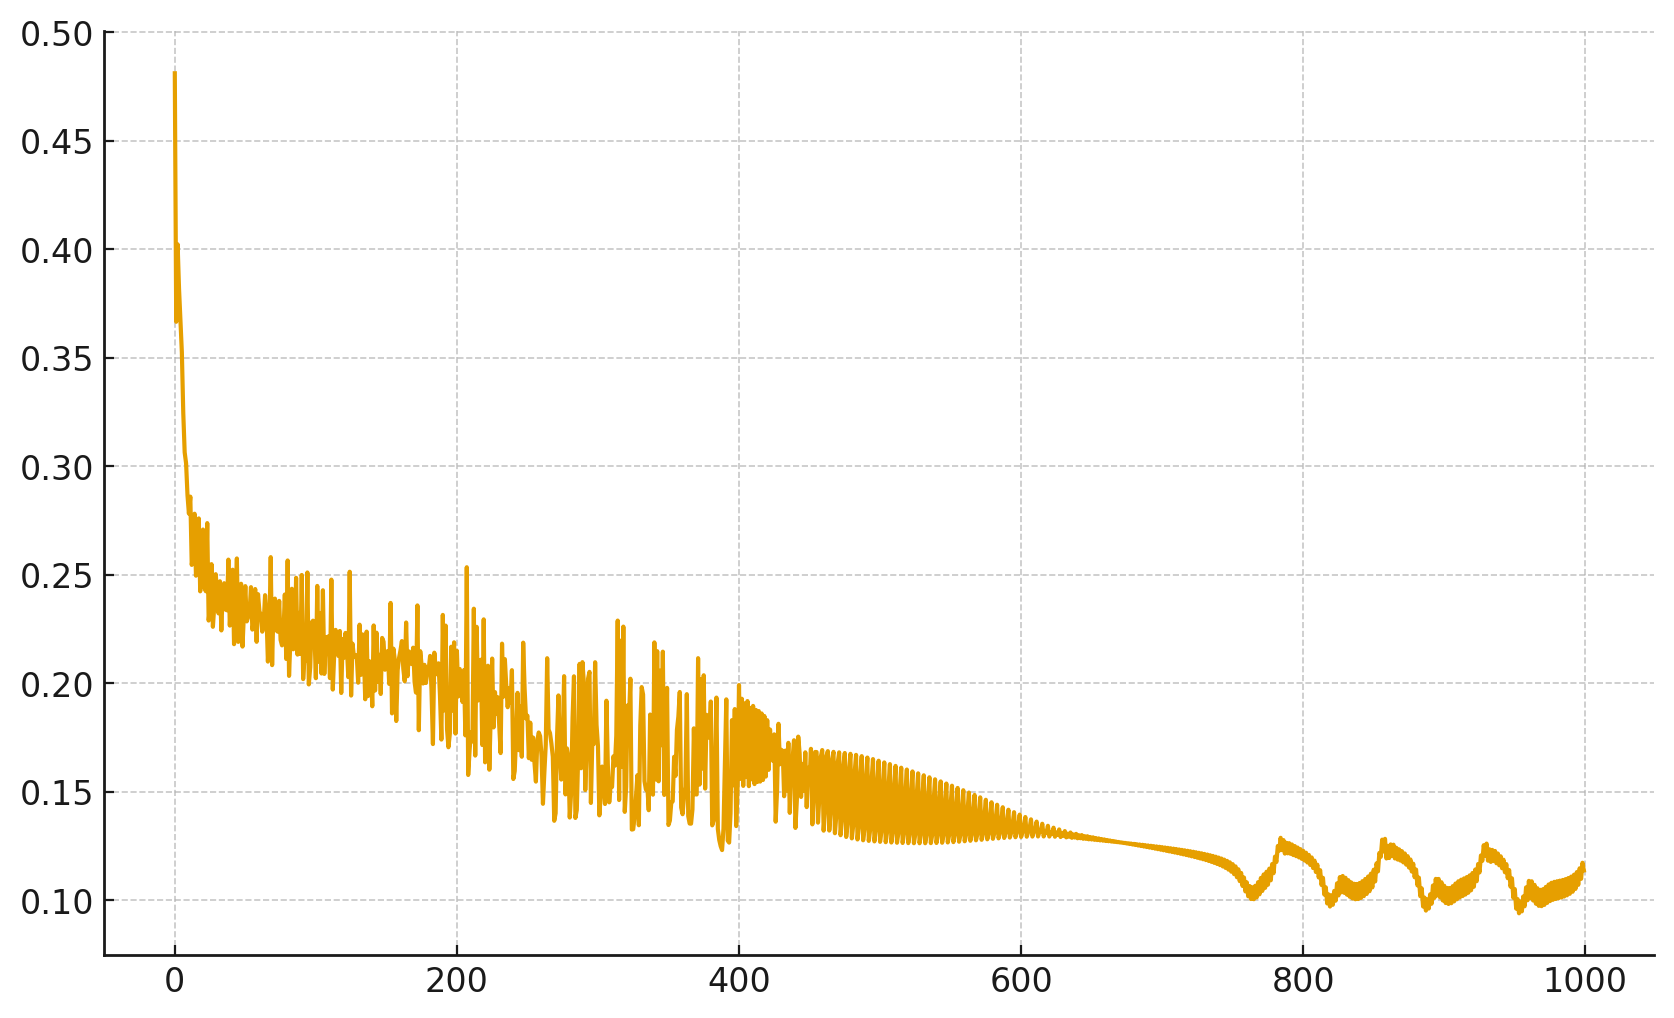

In [20]:
plt.plot(error)

<H2>Test the network for accuracy.</H2>
Run the network with the updated weights from training.

In [21]:
X = test.values[:,:4]
y = np.array([targets[int(x)] for x in test.values[:,4:5]])

l1 = 1/(1 + np.exp(-(np.dot(X, w1))))
l2 = 1/(1 + np.exp(-(np.dot(l1, w2))))

np.round(l2,3)

array([[0.994, 0.004, 0.004],
       [0.997, 0.115, 0.001],
       [0.997, 0.014, 0.005],
       [0.002, 0.999, 0.   ],
       [0.   , 0.984, 0.03 ],
       [0.001, 0.988, 0.007],
       [0.   , 0.851, 0.254],
       [0.   , 0.961, 0.052],
       [0.   , 0.975, 0.025],
       [0.   , 0.334, 0.718],
       [0.   , 0.325, 0.727],
       [0.   , 0.18 , 0.822],
       [0.   , 0.145, 0.856]])

From the above maxtrix we take the maximum value (per row), which forms our predictions...

In [22]:
yp = np.argmax(l2, axis=1) # prediction
res = yp == np.argmax(y, axis=1)
correct = np.sum(res)/len(res)

testres = test[['Species']].replace([0,1,2], ['Iris-setosa','Iris-versicolor','Iris-virginica'])

testres['Prediction'] = yp
testres['Prediction'] = testres['Prediction'].replace([0,1,2], ['Iris-setosa','Iris-versicolor','Iris-virginica'])

print(testres)
print('Correct:',sum(res),'/',len(res), ':', (correct*100),'%')

             Species       Prediction
5        Iris-setosa      Iris-setosa
8        Iris-setosa      Iris-setosa
42       Iris-setosa      Iris-setosa
55   Iris-versicolor  Iris-versicolor
69   Iris-versicolor  Iris-versicolor
71   Iris-versicolor  Iris-versicolor
89   Iris-versicolor  Iris-versicolor
92   Iris-versicolor  Iris-versicolor
94   Iris-versicolor  Iris-versicolor
101   Iris-virginica   Iris-virginica
111   Iris-virginica   Iris-virginica
112   Iris-virginica   Iris-virginica
135   Iris-virginica   Iris-virginica
Correct: 13 / 13 : 100.0 %


In [23]:
print("Patched pairplot(s):", 1)

Patched pairplot(s): 1
